In [1]:
# Cellule 1 — Imports et chargements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Charger modèle + scaler du modèle 11
model = joblib.load("artifacts_diab_no_bias/model_lightgbm_diab_no_bias.pkl")
scaler = joblib.load("artifacts_diab_no_bias/scaler_diab_no_bias.pkl")

# Charger les CSV test créés dans le notebook 15
X_test = pd.read_csv("X_test_chol.csv")
y_test = pd.read_csv("y_test_chol.csv").values.ravel()

print("OK — modèle, scaler et données test chargés.")
print("Shape X_test :", X_test.shape)


OK — modèle, scaler et données test chargés.
Shape X_test : (1378, 13)


In [2]:
# Cellule 2 — Reconstruction des colonnes numériques et binaires (exact modèle 11)

# Colonnes utilisées dans le modèle 11
ethn = [
    "ethnicity_MexicanAmerican", "ethnicity_OtherHispanic",
    "ethnicity_NonHispanicWhite", "ethnicity_NonHispanicBlack",
    "ethnicity_NonHispanicAsian", "ethnicity_OtherRace"
]

binary_cols = ["RIAGENDR", "smoker"] + ethn
binary_cols = [c for c in binary_cols if c in X_test.columns]

# Le reste = colonnes numériques
num_cols = [c for c in X_test.columns if c not in binary_cols]

print("Colonnes binaires :", binary_cols)
print("Colonnes numériques :", num_cols)


Colonnes binaires : ['RIAGENDR', 'smoker', 'ethnicity_MexicanAmerican', 'ethnicity_OtherHispanic', 'ethnicity_NonHispanicWhite', 'ethnicity_NonHispanicBlack', 'ethnicity_NonHispanicAsian', 'ethnicity_OtherRace']
Colonnes numériques : ['RIDAGEYR', 'BMXBMI_log', 'BMXWAIST', 'PAD680_log', 'SLD012']


In [3]:
# Cellule 3 - Re-standardiser X_test comme dans le modèle 11
X_test_scaled = X_test.copy()
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

print("OK — X_test_scaled reconstruit.")


OK — X_test_scaled reconstruit.


In [4]:
# Cellule 4 : predicitions avec un seuil de 0.40 

THRESHOLD = 0.40

probas = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (probas >= THRESHOLD).astype(int)

print("Rapport de classification (seuil = 0.40) :\n")
print(classification_report(y_test, y_pred, digits=3))
print("Matrice de confusion :\n")
print(confusion_matrix(y_test, y_pred))


Rapport de classification (seuil = 0.40) :

              precision    recall  f1-score   support

           0      0.977     0.621     0.759      1223
           1      0.228     0.884     0.362       155

    accuracy                          0.650      1378
   macro avg      0.602     0.752     0.561      1378
weighted avg      0.893     0.650     0.714      1378

Matrice de confusion :

[[759 464]
 [ 18 137]]


In [5]:
# Cellule 5 : identifier les FN et les FP

# Faux négatifs = vrais 1 mais prédits 0
FN_mask = (y_test == 1) & (y_pred == 0)

# Faux positifs = vrais 0 mais prédits 1
FP_mask = (y_test == 0) & (y_pred == 1)

df_FN = X_test.copy()
df_FN["y_true"] = y_test
df_FN["proba"] = probas
df_FN = df_FN[FN_mask]

df_FP = X_test.copy()
df_FP["y_true"] = y_test
df_FP["proba"] = probas
df_FP = df_FP[FP_mask]

print(f"Faux négatifs (FN) : {len(df_FN)}")
print(f"Faux positifs (FP) : {len(df_FP)}")


Faux négatifs (FN) : 18
Faux positifs (FP) : 464


In [6]:
# Cellule 6 — Statistiques descriptives FN / FP / ALL

stats_all = X_test.describe().T[["mean","std"]]

stats_FN = df_FN.describe().T[["mean","std","min","max"]]
stats_FP = df_FP.describe().T[["mean","std","min","max"]]

# Fusion propre
df_compare = stats_all.copy()
df_compare = df_compare.rename(columns={"mean":"mean_all","std":"std_all"})
df_compare["mean_FN"] = stats_FN["mean"]
df_compare["std_FN"]  = stats_FN["std"]
df_compare["mean_FP"] = stats_FP["mean"]
df_compare["std_FP"]  = stats_FP["std"]

df_compare


,mean_all,std_all,mean_FN,std_FN,mean_FP,std_FP
RIDAGEYR,45.509434,22.266661,48.722222,18.022227,62.551724,11.504038
RIAGENDR,1.554427,0.497209,1.666667,0.485071,1.523707,0.499977
smoker,0.319303,0.466376,0.333333,0.485071,0.480603,0.500163
BMXBMI_log,3.341736,0.255694,3.407975,0.209329,3.472198,0.204308
BMXWAIST,95.411176,18.934874,98.672222,16.435428,106.712716,14.056548
PAD680_log,5.690655,0.693841,5.414941,0.625387,5.703005,0.803492
SLD012,7.783019,1.459231,7.666667,0.907485,7.831897,1.727298


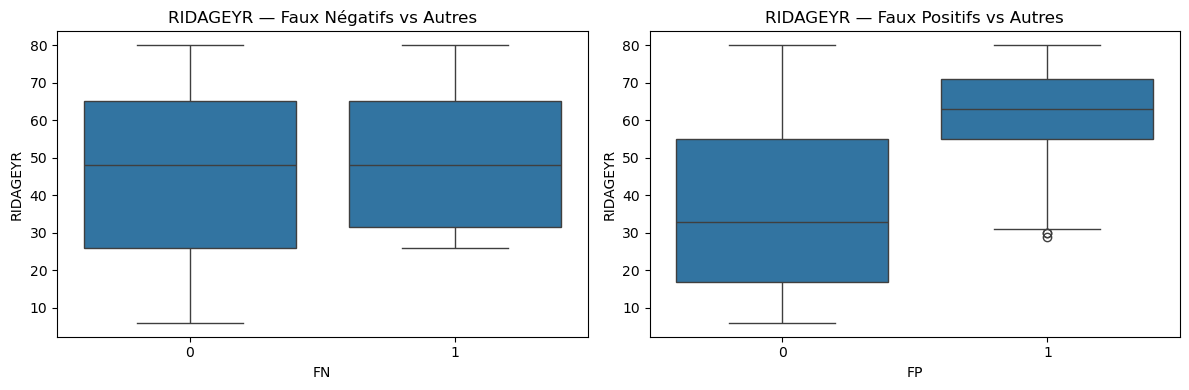

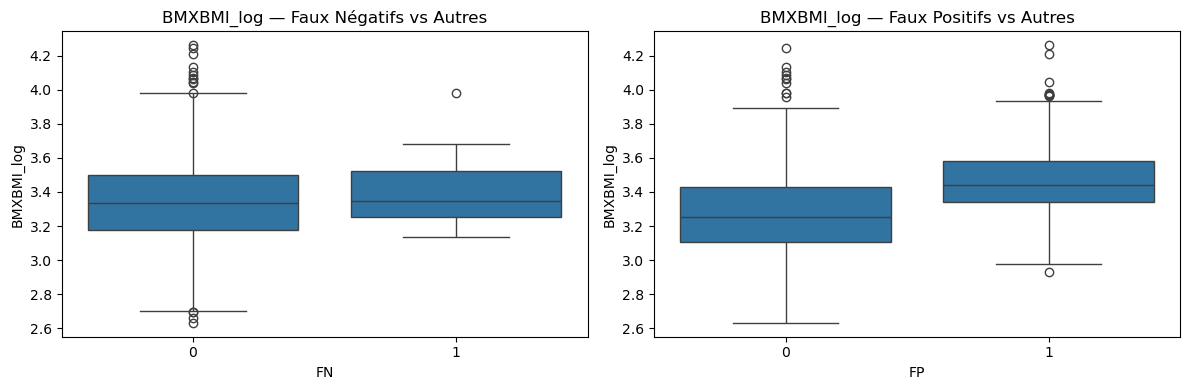

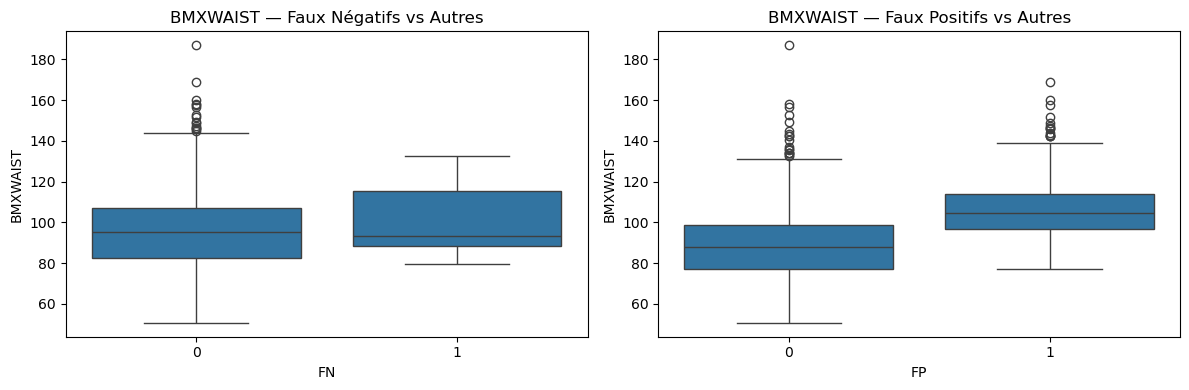

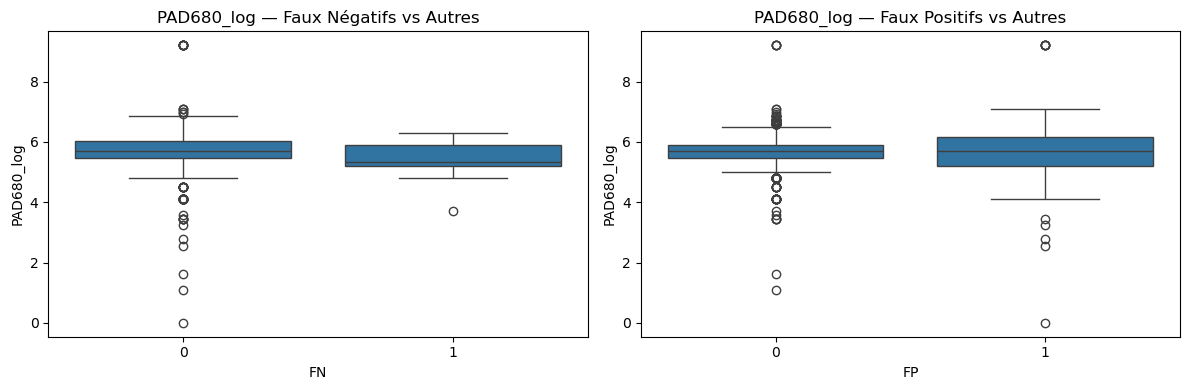

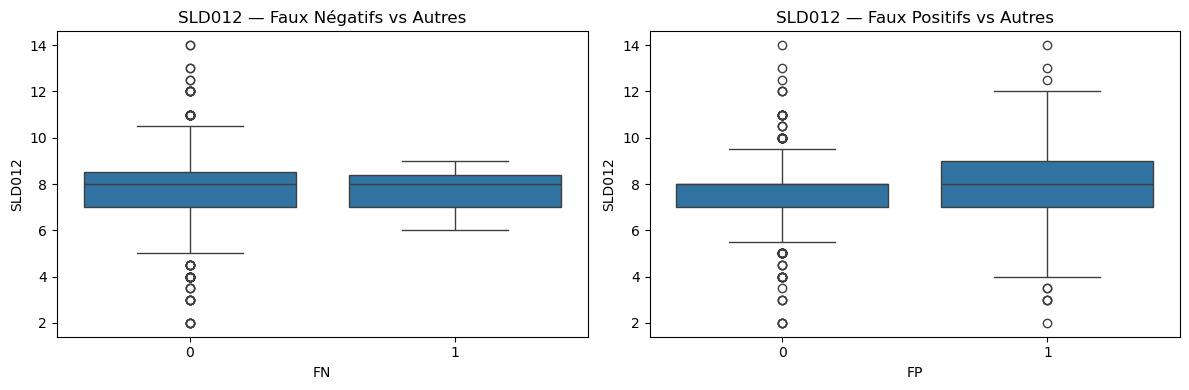

In [7]:
# Cellule 7 — Boxplots comparatifs FN / FP / NON-FN / NON-FP

df_plot = X_test.copy()
df_plot["FN"] = FN_mask.astype(int)
df_plot["FP"] = FP_mask.astype(int)

for col in num_cols:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.boxplot(data=df_plot, x="FN", y=col)
    plt.title(f"{col} — Faux Négatifs vs Autres")

    plt.subplot(1,2,2)
    sns.boxplot(data=df_plot, x="FP", y=col)
    plt.title(f"{col} — Faux Positifs vs Autres")

    plt.tight_layout()
    plt.show()


In [8]:
# Cellule 8 — Analyse des probabilités pour FN / FP

df_proba = pd.DataFrame({
    "y_true": y_test,
    "proba": probas,
    "pred": y_pred,
    "FN": FN_mask.astype(int),
    "FP": FP_mask.astype(int)
})

print("Résumé des probabilités pour les FN :")
print(df_proba[df_proba["FN"]==1]["proba"].describe())

print("\nRésumé des probabilités pour les FP :")
print(df_proba[df_proba["FP"]==1]["proba"].describe())


Résumé des probabilités pour les FN :
count    18.000000
mean      0.269770
std       0.098881
min       0.028419
25%       0.259546
50%       0.276369
75%       0.325077
max       0.395160
Name: proba, dtype: float64

Résumé des probabilités pour les FP :
count    464.000000
mean       0.618718
std        0.129745
min        0.401299
25%        0.511565
50%        0.606780
75%        0.712279
max        0.935215
Name: proba, dtype: float64


In [9]:
# Cellule 9 : proportion parmi les FP des femmes de plus de 60 ans
# avec IMC et tour de taille eleves

# --- Seuils médicaux ---
age_threshold = 60
bmi_threshold = 30
waist_threshold = 88   # Seuil OMS femme, risque cardio-métabolique

# --- Recalcul de l'IMC réel ---
if "BMXBMI" in df_FP.columns:
    df_FP["BMI"] = df_FP["BMXBMI"]
else:
    df_FP["BMI"] = np.exp(df_FP["BMXBMI_log"])

# --- Conditions ---
cond_femme = df_FP["RIAGENDR"] == 2
cond_age = df_FP["RIDAGEYR"] >= age_threshold
cond_bmi = df_FP["BMI"] >= bmi_threshold
cond_waist = df_FP["BMXWAIST"] >= waist_threshold

df_FP_critique = df_FP[cond_femme & cond_age & cond_bmi & cond_waist]

# --- Résultats ---
n_FP = len(df_FP)
n_FP_critique = len(df_FP_critique)
ratio = n_FP_critique / n_FP if n_FP > 0 else 0

print(f"Nombre total de faux positifs : {n_FP}")
print(f"Faux positifs femme >60 ans IMC élevé + taille élevée : {n_FP_critique}")
print(f"Proportion : {ratio:.3f} ({ratio*100:.1f} %)")
df_FP_critique.head()


Nombre total de faux positifs : 464
Faux positifs femme >60 ans IMC élevé + taille élevée : 88
Proportion : 0.190 (19.0 %)


,RIDAGEYR,RIAGENDR,smoker,BMXBMI_log,BMXWAIST,PAD680_log,SLD012,ethnicity_MexicanAmerican,ethnicity_OtherHispanic,ethnicity_NonHispanicWhite,ethnicity_NonHispanicBlack,ethnicity_NonHispanicAsian,ethnicity_OtherRace,y_true,proba,BMI
13,80.0,2,0,3.411148,101.5,6.175867,8.5,False,False,True,False,False,False,0,0.556082,30.3
14,64.0,2,1,3.424263,99.5,5.888878,7.0,False,False,False,True,False,False,0,0.710964,30.7
55,74.0,2,0,3.713572,112.5,5.198497,7.5,False,False,True,False,False,False,0,0.574374,41.0
57,65.0,2,1,3.456317,110.4,5.888878,8.0,False,False,True,False,False,False,0,0.691515,31.7
70,73.0,2,0,3.923952,129.9,6.398595,9.0,False,False,True,False,False,False,0,0.847150,50.6
